# Temperature Volatility Models

<b> YouTube Tutorial </b> (Published: Aug 22, 2022): https://youtu.be/Kjpf4cvfsC0

Now that we have a defined the parameters of our modified mean-reverting Ornstein-Uhlenbeck process which defines our Temperature dynamics, in this tutorial we will now be looking to implement different models for our time varying volatility patterns.

We have a number of options to model temperature volatility across seasons.

1. Piece-wise constant functions (volatility for each season)
2. Parametric Regression - Polynomial
3. Local and Nonparametric Regression - Splines
4. Fourier series to model the volatility of temperature
5. Stochastic differential equation

### Install and Import dependencies

In [ ]:
!pip install statsmodels --upgrade
!pip install symfit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 4.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 456 kB/s 


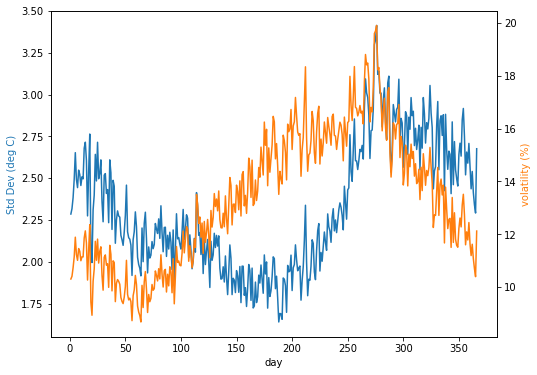

In [ ]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from scipy.stats import norm
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


dir_path = os.path.dirname(os.path.realpath('__file__'))
data_folder = os.path.join(dir_path, 'statistical analysis')
max_temp = pd.read_csv('https://raw.githubusercontent.com/ASXPortfolio/jupyter-notebooks-data/main/maximum_temperature.csv')
min_temp = pd.read_csv('https://raw.githubusercontent.com/ASXPortfolio/jupyter-notebooks-data/main/minimum_temperature.csv')

def datetime(row):
    return dt.datetime(row.Year,row.Month,row.Day)

max_temp['Date'] = max_temp.apply(datetime,axis=1)
min_temp['Date'] = min_temp.apply(datetime,axis=1)
max_temp.set_index('Date', inplace=True)
min_temp.set_index('Date', inplace=True)
drop_cols = [0,1,2,3,4,6,7]
max_temp.drop(max_temp.columns[drop_cols],axis=1,inplace=True)
min_temp.drop(min_temp.columns[drop_cols],axis=1,inplace=True)
max_temp.rename(columns={'Maximum temperature (Degree C)':'Tmax'}, inplace=True)
min_temp.rename(columns={'Minimum temperature (Degree C)':'Tmin'}, inplace=True)

temps = max_temp.merge(min_temp,how='inner',left_on=['Date'],right_on=['Date'])

def avg_temp(row):
    return (row.Tmax+row.Tmin)/2

temps['T'] = temps.apply(avg_temp,axis=1)

# drop na values here
temps = temps.dropna()

temp_t = temps['T'].copy(deep=True)
temp_t = temp_t.to_frame()

temp_t['day'] = temp_t.index.dayofyear
temp_t['month'] = temp_t.index.month

vol = temp_t.groupby(['day'])['T'].agg(['mean','std'])
vol['volatility (%)'] = np.where(vol['std'] > 0, vol['std']/vol['mean']*100, vol['std'])

vol['std'].plot(color='tab:blue', figsize=(8,6))
plt.ylabel('Std Dev (deg C)',color='tab:blue')
vol['volatility (%)'].plot(color='tab:orange',secondary_y=True)
plt.ylabel('volatility (%)',color='tab:orange')
plt.show()

## Summary of our Modified OU Dynamics

We Finally have our dynamics well described and we're convinced that the expectation of this stochastic process is equal to the longrun average (while constantly changing) of our Daily Average Temperature (DAT).

$\large dT_t = \left[\frac{d\bar{T_t}}{dt} + 0.438 (\bar{T_t} - T_t)\right]dt + \sigma_t dW_t$

Where our changing average of DAT $\large \bar{T_t}$ is:

$\large \bar{T_t} = 16.8 + (3.32e-05)t + 5.05 sin((\frac{2\pi}{365.25})t + 1.27)$

First derivative does not need finite difference approximation here because the function is differentiable $\large \bar{T'_t}$

$\large \bar{T'_t} = (3.32e-05) + 5.05 (\frac{2\pi}{365.25}) cos((\frac{2\pi}{365.25})t + 1.27)$

Where the date <b>01-Jan 1859</b> corresponds with the first ordinal number 0.

## Volatility of Temperature Process

 The volatility estimator is based on the the quadratic variation of of the temperature process $\Large T_t$

 $\Large \hat{\sigma}_t = \sqrt{ \frac{1}{N_t} \sum^{N-1}_{i=0} (T_{i+1} - T_i)^2 }$

$\Large \sigma_t$ is the dynamic volatility of the Temperature process. This could be both daily (as with our temperature dynamics) or seasonal (for example monthly)

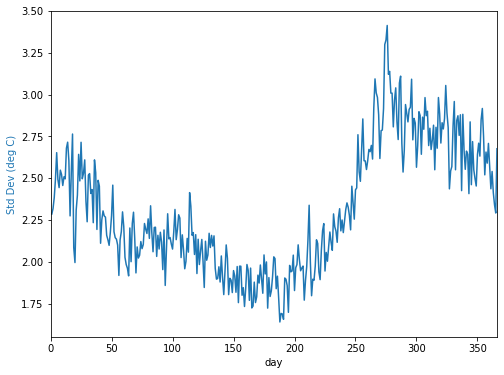

In [ ]:
vol = temp_t.groupby(['day'])['T'].agg(['mean','std'])
vol['std'].plot(color='tab:blue', figsize=(8,6))
plt.ylabel('Std Dev (deg C)',color='tab:blue')
plt.xlim(0,366)
plt.show()

# Piece-wise constant functions

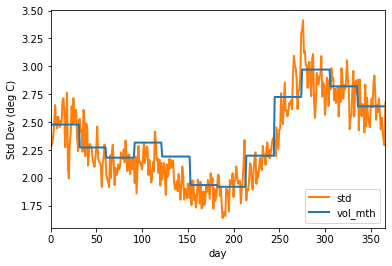

In [ ]:
vol_days = temp_t.groupby(['day'])['T'].agg(['mean','std'])
vol_mths = temp_t.groupby(['month'])['T'].agg(['mean','std'])

vol_days["days"] = vol_days.index
def change_month(row):
    date = dt.datetime(2016, 1, 1) + dt.timedelta(row.days - 1)
    return vol_mths.loc[date.month,'std']

vol_days['vol_mth'] = vol_days.apply(change_month, axis=1)

vol_days[['std', 'vol_mth']].plot(color=['tab:orange','tab:blue'],linewidth=2)
plt.ylabel('Std Dev (deg C)')
plt.xlim(0,366)
plt.legend(loc='lower right')
plt.show()

# Parametric Regression - Polynomials

In [ ]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

# Preprocess x, y combinations to handle dimensionality of Polynomial Features
x = np.array(vol['std'].index)
y = np.array(vol['std'].values)

#Create single dimension
x= x[:,np.newaxis]
y= y[:,np.newaxis]

inds = x.ravel().argsort()  # Sort x values and get index
x = x.ravel()[inds].reshape(-1,1)
y = y[inds] #Sort y according to x sorted index

# initialise degrees of freedom
poly_feats3 = PolynomialFeatures(degree=3)
poly_feats4 = PolynomialFeatures(degree=4)
poly_feats5 = PolynomialFeatures(degree=5)
poly_feats6 = PolynomialFeatures(degree=6)
poly_feats7 = PolynomialFeatures(degree=7)

# Fit transform to number of polynomial features
xp3 = poly_feats3.fit_transform(x)
xp4 = poly_feats4.fit_transform(x)
xp5 = poly_feats5.fit_transform(x)
xp6 = poly_feats6.fit_transform(x)
xp7 = poly_feats7.fit_transform(x)

# Fit using ordinary least squares
p3 = sm.OLS(y, xp3).fit()
p4 = sm.OLS(y, xp4).fit()
p5 = sm.OLS(y, xp5).fit()
p6 = sm.OLS(y, xp6).fit()
p7 = sm.OLS(y, xp7).fit()

# Predict using original data and model fit
poly3 = p3.predict(xp3)
poly4 = p4.predict(xp4)
poly5 = p5.predict(xp5)
poly6 = p6.predict(xp6)
poly7 = p7.predict(xp7)

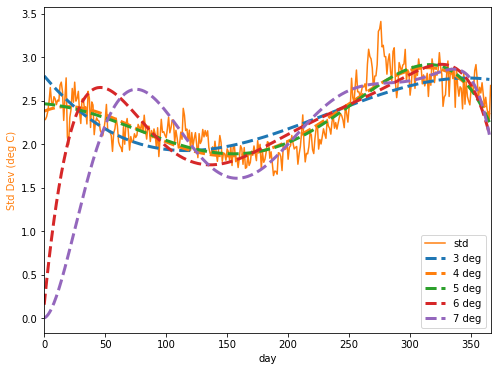

In [ ]:
vol = temp_t.groupby(['day'])['T'].agg(['mean','std'])
vol['std'].plot(color='tab:orange', figsize=(8,6))
plt.plot(poly3, '--', linewidth=3, label='3 deg')
plt.plot(poly4, '--', linewidth=3, label='4 deg')
plt.plot(poly5, '--', linewidth=3, label='5 deg')
plt.plot(poly6, '--', linewidth=3, label='6 deg')
plt.plot(poly7, '--', linewidth=3, label='7 deg')
plt.ylabel('Std Dev (deg C)',color='tab:orange')
plt.xlim(0,366)
plt.legend(loc='lower right')
plt.show()

## Choose Model by Parsimony

Using the Akaike information criterion to judge parsimony between model fit and complexity.

$\Large AIC = 2k - 2ln(\hat{L})$

where $k$ is the numbers of parameters and $\hat{L}$ is the log-likelihood

In [ ]:
p3.aic, p4.aic, p5.aic, p6.aic, p7.aic

(-40.44890721463514,
 -211.17126428703784,
 -217.54752159271777,
 398.15342156621955,
 728.338820047069)

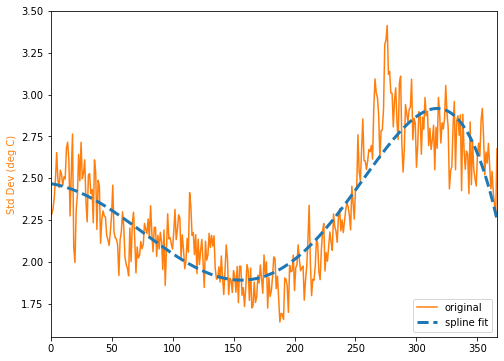

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(x, y, color='tab:orange', label='original')
plt.plot(x, poly5, '--', linewidth=3, label='spline fit')
plt.ylabel('Std Dev (deg C)',color='tab:orange')
plt.xlim(0,366)
plt.legend(loc='lower right')
plt.show()

# Local and Nonparametric Regression - Splines

Interpolation is a method of estimating unknown data points in a given range. Spline interpolation is a type of piecewise polynomial interpolation method. Spline interpolation is a useful method in smoothing the curve or surface data.   

## B-spline curve fitting
[B-spline or basis spline](https://cran.r-project.org/web/packages/crs/vignettes/spline_primer.pdf) is a curve approximation method, and requires the parameters such as knots, spline coefficients, and degree of a spline. To construct a smoother spline fit, we need to specify the number of knots for the target data.
<b>Knots</b> are joints of polynomial segments.

### Steps
1. Based on knots number, we'll determine the new x data vector by using the <i>quantile</i> function.
2. <i>splrep</i> function returns tuple containing the vector of:
 - knots
 - B-spline coefficients
 - degree of the spline
3. Use <i>BSpline</i> class to construct spline fit on x vector data.


In [ ]:
from scipy import interpolate

x = np.array(vol['std'].index)
y = np.array(vol['std'].values)

knot_numbers = 5
x_new = np.linspace(0, 1, knot_numbers+2)[1:-1]
q_knots = np.quantile(x, x_new)
t,c,k = interpolate.splrep(x, y, t=q_knots, s=1)
yfit = interpolate.BSpline(t,c,k)(x)

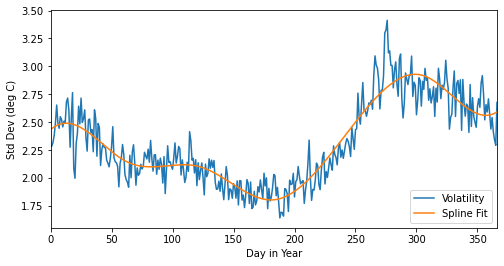

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(x, y, label='Volatility')
plt.plot(x, yfit, label='Spline Fit')
plt.ylabel('Std Dev (deg C)')
plt.xlabel('Day in Year')
plt.xlim(0,366)
plt.legend(loc='lower right')
plt.show()

In [ ]:
def spline(knots, x, y):
    x_new = np.linspace(0, 1, knots+2)[1:-1]
    t, c, k = interpolate.splrep(x, y, t=np.quantile(x, x_new), s=3)
    yfit = interpolate.BSpline(t,c, k)(x)
    return yfit

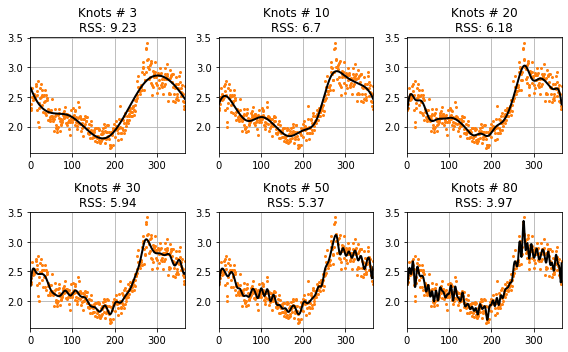

In [ ]:
knots = [3, 10, 20, 30, 50, 80]
i = 0

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 5))

for row in range(2):
    for col in range(3):
        ax[row][col].plot(x, y, '.',c='tab:orange', markersize=4)
        yfit = spline(knots[i], x, y)
        rss = np.sum( np.square(y-yfit) )
        ax[row][col].plot(x, yfit, 'k', linewidth=2)
        ax[row][col].set_title("Knots # "+str(knots[i])+"\nRSS: "+str(round(rss,2)), color='k')
        ax[row][col].set_xlim(0,366)
        ax[row][col].grid()
        i=i+1

plt.tight_layout()
plt.show()

# Fourier series to model the volatility of temperature

[Fourier Series Fit in Python](https://stackoverflow.com/questions/52524919/fourier-series-fit-in-python)

$\Large \sigma_t = a_0 + \sum^I_{i=1} a_i cos(i\omega t) + \sum^J_{j=1} b_j sin(j\omega t)$

### Let's take a look at long term volatility

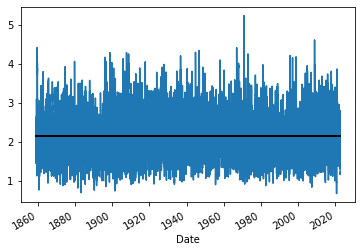

In [ ]:
std = temp_t['T'].rolling(30).std()

std.plot()
plt.plot([std.index[0], std.index[-1]], [std.mean(),std.mean()], 'k', linewidth=2)
plt.show()

In [ ]:
from symfit import parameters, variables, sin, cos, Fit

def fourier_series(x, f, n=0):
    """
    Returns a symbolic fourier series of order `n`.

    :param n: Order of the fourier series.
    :param x: Independent variable
    :param f: Frequency of the fourier series
    """
    # Make the parameter objects for all the terms
    f=2*np.pi/365.25
    a0, *cos_a = parameters(','.join(['a{}'.format(i) for i in range(0, n + 1)]))
    sin_b = parameters(','.join(['b{}'.format(i) for i in range(1, n + 1)]))
    # Construct the series
    series = a0 + sum(ai * cos(i * f * x) + bi * sin(i * f * x)
                     for i, (ai, bi) in enumerate(zip(cos_a, sin_b), start=1))
    return series

x, y = variables('x, y')

# Define frequency as yearly
w = 2*np.pi/365.25
model_dict = {y: fourier_series(x, f=w, n=3)}
print('Example of Fourier Model \n', model_dict)

if isinstance(std.index , pd.DatetimeIndex):
    first_ord = std.index.map(dt.datetime.toordinal)[0]
    std.index=std.index.map(dt.datetime.toordinal)

time_mask = -int(30*365.25)

# Make step function data
xdata = std.index[time_mask:] - first_ord
ydata = np.array(std[time_mask:])

Example of Fourier Model 
 {y: a0 + a1*cos(0.0172024238389585*x) + a2*cos(0.034404847677917*x) + a3*cos(0.0516072715168755*x) + b1*sin(0.0172024238389585*x) + b2*sin(0.034404847677917*x) + b3*sin(0.0516072715168755*x)}


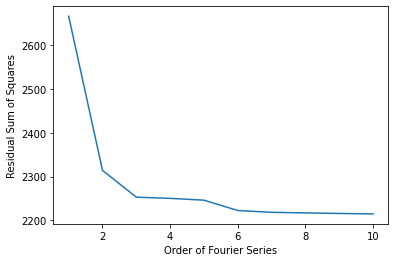

In [ ]:
rss = []
for fourier_order in range(1,11):
    model_dict = {y: fourier_series(x, f=w, n=fourier_order)}

    # Define a Fit object for this model and data
    fit = Fit(model_dict, x=xdata, y=ydata)
    fit_result = fit.execute()
    rss.append(fit_result.chi_squared)

plt.plot(range(1,11),rss)
plt.ylabel('Residual Sum of Squares')
plt.xlabel('Order of Fourier Series')
plt.show()

Fourier Series Parameters:
a0 2.133
a1 0.386
a2 -0.135
a3 0.012
a4 0.006
a5 0.003
a6 -0.04
b1 -0.241
b2 -0.215
b3 0.105
b4 0.022
b5 -0.027
b6 -0.052


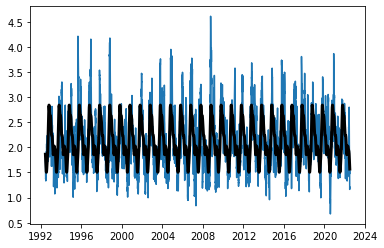

In [ ]:
model_dict = {y: fourier_series(x, f=w, n=6)}

# Define a Fit object for this model and data
fit = Fit(model_dict, x=xdata, y=ydata)
fit_result = fit.execute()

# Map back to datetime from ordinal
xdata2=(xdata+first_ord).map(dt.datetime.fromordinal)

# Plot the result
plt.plot(xdata2, ydata)
plt.plot(xdata2, fit.model(x=xdata, **fit_result.params).y, 'k-', linewidth=3)

print("Fourier Series Parameters:")
for i,v in fit_result.params.items():
    print(i,round(v,3))

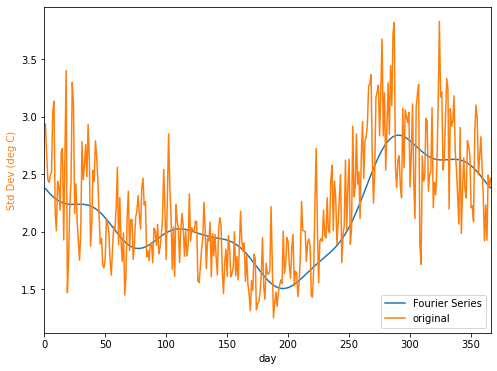

In [ ]:
fourier = pd.DataFrame({'date':xdata2,
                        'day':xdata2.dayofyear,
                        'volatility':ydata,
                        'model':fit.model(x=xdata, **fit_result.params).y})
fourier.index = fourier.date
fourier = fourier.drop(columns='date')
fourier_model = fourier.groupby(['day'])['model'].agg(['mean','std'])

vol = temp_t[time_mask:].groupby(['day'])['T'].agg(['mean','std'])
x = np.array(vol['std'].index)
y = np.array(vol['std'].values)

fourier_model['mean'].plot(color='tab:blue', figsize=(8,6), label='Fourier Series')
plt.ylabel('Std Dev (deg C)',color='tab:orange')

plt.plot(x, y, color='tab:orange', label='original')
plt.xlim(0,366)
plt.legend(loc='lower right')
plt.show()

# Stochastic Differential Equation

$\large dT_t = \left[\frac{d\bar{T_t}}{dt} + 0.438 (\bar{T_t} - T_t)\right]dt + \sigma_t dW_{1,t}$

$\large d\sigma_t = k_\sigma (\bar{\sigma_t} - \sigma_t)dt + \gamma_t dW_{2,t}$

Trend or long term volatility is easy: ~ 2.149


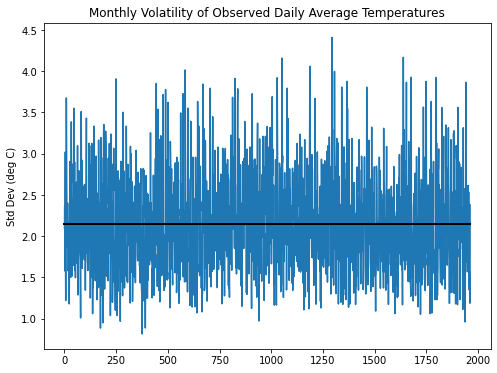

In [ ]:
temp_t['day'] = temp_t.index.dayofyear
temp_t['month'] = temp_t.index.month
temp_t['year'] = temp_t.index.year

vol = temp_t.groupby(['year','month'])['T'].agg(['mean','std'])
vol = vol.reset_index()

vol['std'].plot(figsize=(8,6))
plt.plot([0, len(vol)], [vol['std'].mean(),vol['std'].mean()], 'k', linewidth=2)
plt.ylabel('Std Dev (deg C)')
plt.title('Monthly Volatility of Observed Daily Average Temperatures', color='k',)
print('Trend or long term volatility is easy: ~', round(vol['std'].mean(),3))
plt.show()

### Estimating volatility of volatility process
If we use the estimator presented in Alaton et al.

 The volatility estimator is based on the the quadratic variation of of the volatility process $\Large \sigma_t$

 $\Large \hat{\gamma_t} = \sqrt{ \frac{1}{N_t} \sum^{N-1}_{i=0} (\sigma_{i+1} - \sigma_i)^2 } $

In [ ]:
print('Gamma is: ', round(vol['std'].std(),3))

Gamma is:  0.58


In [ ]:
model = AutoReg(vol['std'], lags=1, old_names=True,trend='n')
model_fit  = model.fit()
coef = model_fit.params
res = model_fit.resid
print('Rate of mean reversion of volatility process is : ', coef[0])
print(model_fit.summary())

Rate of mean reversion of volatility process is :  0.9538808996819312
                            AutoReg Model Results                             
Dep. Variable:                    std   No. Observations:                 1963
Model:                     AutoReg(1)   Log Likelihood               -1990.497
Method:               Conditional MLE   S.D. of innovations              0.667
Date:                Mon, 22 Aug 2022   AIC                           3984.995
Time:                        04:13:38   BIC                           3996.158
Sample:                             1   HQIC                          3989.098
                                 1963                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
std.L1         0.9539      0.007    140.908      0.000       0.941       0.967
                                    Roots                    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:236: FutureWarning: old_names will be removed after the 0.14 release. You should stop setting this parameter and use the new names.
  FutureWarning,


# Stochastic Differential Equation Completed

$\large dT_t = \left[\frac{d\bar{T_t}}{dt} + 0.438 (\bar{T_t} - T_t)\right]dt + \sigma_t dW_{1,t}$

$\large d\sigma_t = 0.954 (2.15 - \sigma_t)dt + 0.580 dW_{2,t}$

In order to simulate paths, we would use the Euler scheme approximation.
1. For each month, $\Large \sigma_t$ is simulated
2. Temperature is simulated for each day within the month